In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import time
import gym
from gym import wrappers

In [20]:
class ReplayBuffer():
    def __init__(self, max_size, n_states):
        self.mem_size = max_size # replay buffer size, max number of experiences to store
        self.mem_cntr = 0  # replay buffer counter (used for indexing later)
        self.state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # When memory counter goes past max replay size, 
                                              # indexes at start of array
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size) # number of experiences in replay buffer
        batch = np.random.choice(max_mem, batch_size, replace=False) # select # experiences to 
                                                                     # train on
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, states_, terminal

class DDQNAgent():
    def __init__(self, env, lr, gamma, epsilon, batch_size, epsilon_dec=1e-3, epsilon_end=0.01,
                 mem_size=1000000):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, self.n_states)
        self.model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        self.target_model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        
    def create_q_network(self, lr, fc1_dims, fc2_dims):
        model = keras.Sequential([
            keras.layers.Dense(fc1_dims, activation='relu', input_shape=(self.n_states,)),
            keras.layers.Dense(fc2_dims, activation='relu'),
            keras.layers.Dense(self.n_actions, activation=None)])
        model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        return model

    def set_new_lr(self, lr):
        self.model.compile(optimizer=Adam(lr), loss='mean_squared_error')

    def add_to_replay_buffer(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = env.action_space.sample()
        else:
            observation = np.expand_dims(observation, axis=0)
            action = np.argmax(self.model.predict(observation))
            
        self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)
        return action

    def copy_across_model_weights(self):
        if self.memory.mem_cntr % 100 == 0:
            weights = self.model.get_weights()
            self.target_model.set_weights(weights)
    
    def learn_from_replay_buffer(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        states, actions, rewards, next_states , dones = self.memory.sample_buffer(self.batch_size) 
        q_states = self.model.predict(states)
        q_next_states = self.target_model.predict(next_states)
        
        q_next_states_double = self.model.predict(next_states)
        max_actions_double = np.argmax(q_next_states_double, axis=1)
        
        q_states[range(len(q_states)), actions] = rewards + self.gamma
                                                 #* np.max(q_next_states, axis=1) # DQN
                                                 * q_next_states[:, max_actions_double] #DDQN
                                                 * (1 - dones) 

        
        self.model.train_on_batch(states, q_states)
        self.copy_across_model_weights()

In [21]:
tf.compat.v1.disable_eager_execution()

# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0' #DONE
env_name = 'LunarLander-v2' #Done
env = gym.make(env_name)

lr = 0.0005
agent = DDQNAgent(env=env, gamma=0.99, epsilon=1.0, lr=lr, mem_size=1000000, batch_size=64, epsilon_dec=1e-4, epsilon_end=0)

In [22]:
highscores = []
epsilons = []

n_games = 500
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        #reward += (abs(next_observation[0]) + 0.3)**2 / 100 # Mountain car exploration
        agent.add_to_replay_buffer(observation, action, reward, next_observation, done)
        agent.learn_from_replay_buffer()
        observation = next_observation
        score += reward
        
    epsilons.append(agent.epsilon)
    highscores.append(score)

    avg_score = np.mean(highscores[-100:])
    print('episode:', i, 'score:', round(score, 2), 'average_score:', round(avg_score), 'epsilon:', round(agent.epsilon, 2))

episode: 0 score: -360.53 average_score: -361.0 epsilon: 0.99
episode: 1 score: -87.79 average_score: -224.0 epsilon: 0.98
episode: 2 score: -139.37 average_score: -196.0 epsilon: 0.97
episode: 3 score: -233.07 average_score: -205.0 epsilon: 0.96
episode: 4 score: -98.41 average_score: -184.0 epsilon: 0.96
episode: 5 score: -316.18 average_score: -206.0 epsilon: 0.95
episode: 6 score: -265.57 average_score: -214.0 epsilon: 0.93
episode: 7 score: -181.95 average_score: -210.0 epsilon: 0.93
episode: 8 score: -111.66 average_score: -199.0 epsilon: 0.92
episode: 9 score: -111.74 average_score: -191.0 epsilon: 0.91
episode: 10 score: -105.04 average_score: -183.0 epsilon: 0.9
episode: 11 score: -173.7 average_score: -182.0 epsilon: 0.89
episode: 12 score: -177.95 average_score: -182.0 epsilon: 0.88
episode: 13 score: -65.67 average_score: -173.0 epsilon: 0.87
episode: 14 score: -103.0 average_score: -169.0 epsilon: 0.86
episode: 15 score: -151.72 average_score: -168.0 epsilon: 0.85
episode:

episode: 138 score: 260.96 average_score: 70.0 epsilon: 0
episode: 139 score: 221.86 average_score: 73.0 epsilon: 0
episode: 140 score: 274.78 average_score: 76.0 epsilon: 0
episode: 141 score: 278.4 average_score: 79.0 epsilon: 0
episode: 142 score: 294.27 average_score: 82.0 epsilon: 0
episode: 143 score: 247.37 average_score: 84.0 epsilon: 0
episode: 144 score: 255.63 average_score: 88.0 epsilon: 0
episode: 145 score: 293.13 average_score: 91.0 epsilon: 0
episode: 146 score: 253.21 average_score: 95.0 epsilon: 0
episode: 147 score: 259.0 average_score: 100.0 epsilon: 0
episode: 148 score: 283.26 average_score: 103.0 epsilon: 0
episode: 149 score: 273.49 average_score: 105.0 epsilon: 0
episode: 150 score: 260.67 average_score: 109.0 epsilon: 0
episode: 151 score: 279.27 average_score: 112.0 epsilon: 0
episode: 152 score: 257.31 average_score: 115.0 epsilon: 0
episode: 153 score: 278.36 average_score: 118.0 epsilon: 0
episode: 154 score: 245.49 average_score: 121.0 epsilon: 0
episode:

episode: 278 score: 263.58 average_score: 246.0 epsilon: 0
episode: 279 score: 246.12 average_score: 246.0 epsilon: 0
episode: 280 score: 281.18 average_score: 247.0 epsilon: 0
episode: 281 score: 259.79 average_score: 247.0 epsilon: 0
episode: 282 score: 249.55 average_score: 247.0 epsilon: 0
episode: 283 score: 279.06 average_score: 247.0 epsilon: 0
episode: 284 score: 290.7 average_score: 247.0 epsilon: 0
episode: 285 score: 278.28 average_score: 247.0 epsilon: 0
episode: 286 score: 268.3 average_score: 253.0 epsilon: 0
episode: 287 score: 250.38 average_score: 252.0 epsilon: 0
episode: 288 score: 290.91 average_score: 252.0 epsilon: 0
episode: 289 score: 252.48 average_score: 252.0 epsilon: 0
episode: 290 score: 162.32 average_score: 252.0 epsilon: 0
episode: 291 score: 255.0 average_score: 252.0 epsilon: 0
episode: 292 score: 276.74 average_score: 252.0 epsilon: 0
episode: 293 score: 238.95 average_score: 252.0 epsilon: 0
episode: 294 score: 261.35 average_score: 252.0 epsilon: 0


episode: 418 score: 262.72 average_score: 230.0 epsilon: 0
episode: 419 score: 269.88 average_score: 229.0 epsilon: 0
episode: 420 score: 254.7 average_score: 229.0 epsilon: 0
episode: 421 score: 261.64 average_score: 229.0 epsilon: 0
episode: 422 score: 245.48 average_score: 229.0 epsilon: 0
episode: 423 score: -59.96 average_score: 226.0 epsilon: 0
episode: 424 score: 250.47 average_score: 226.0 epsilon: 0
episode: 425 score: 23.98 average_score: 224.0 epsilon: 0
episode: 426 score: 247.92 average_score: 224.0 epsilon: 0
episode: 427 score: 278.51 average_score: 225.0 epsilon: 0
episode: 428 score: 275.97 average_score: 226.0 epsilon: 0
episode: 429 score: 248.82 average_score: 226.0 epsilon: 0
episode: 430 score: 204.08 average_score: 230.0 epsilon: 0
episode: 431 score: 278.3 average_score: 230.0 epsilon: 0
episode: 432 score: 277.58 average_score: 231.0 epsilon: 0
episode: 433 score: 231.68 average_score: 231.0 epsilon: 0
episode: 434 score: 268.44 average_score: 231.0 epsilon: 0


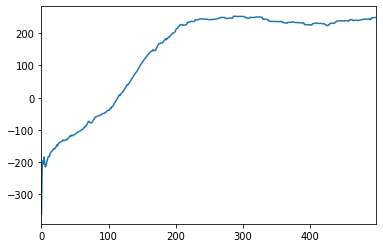

In [23]:
import pandas as pd
pd.Series(highscores).rolling(window=100, min_periods=1).mean().plot()

In [37]:
test_highscores = []

for i in range(1):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        env.render()
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        observation = next_observation
        score += reward
        
    test_highscores.append(score)
    
env.close()
test_highscores

[249.9164101385917]